# Hallucination Detection

In [1]:
import re
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import BertTokenizer, BertModel

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

In [2]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

In [3]:
from nltk import wsd
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import wordnet as wn
from spacy.cli import download
from spacy import load
import warnings

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')
nlp = load('en_core_web_sm')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


In [4]:
# Load dataset
df = pd.read_csv("/kaggle/input/ml-olympiad-detect-hallucinations-in-llms/train.csv")
df.fillna("", inplace=True)

## Exploratory Data Analysis

In [5]:
# EDA - Dataset Overview
print("Dataset Overview:")
print(df.head())
print("\nClass Distribution:")
print(df["Target"].value_counts())

Dataset Overview:
      Id                                             Prompt  \
0  11527  [INST] You are an AI assistant that helps peop...   
1   7322  [INST] You are an AI assistant. You will be gi...   
2  11742  [INST] You are an AI assistant. You will be gi...   
3  20928  [INST] You are an AI assistant. User will you ...   
4  25830  [INST] You are an AI assistant. User will you ...   

                                              Answer  Target  
0  Step-by-step reasoning process:\n1. Randy spen...       0  
1  What is the temperature at which hypothermia b...       0  
2  Answer: c) No. \n\nThe hypothesis is false bec...       0  
3                                         Prismatoid       0  
4                                             Case B       0  

Class Distribution:
Target
0    15793
1      894
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


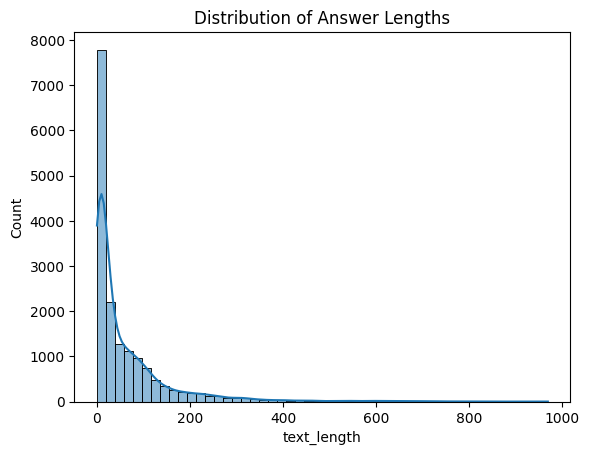

In [6]:
# EDA - Text Length Analysis
df["text_length"] = df["Answer"].apply(lambda x: len(x.split()))
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Distribution of Answer Lengths")
plt.show()

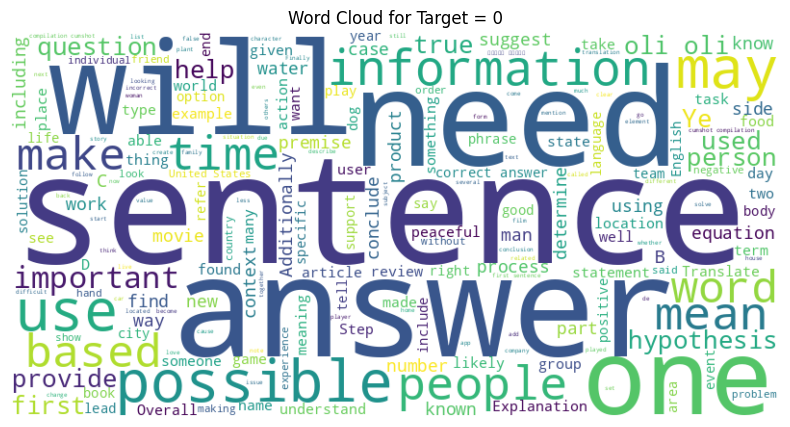

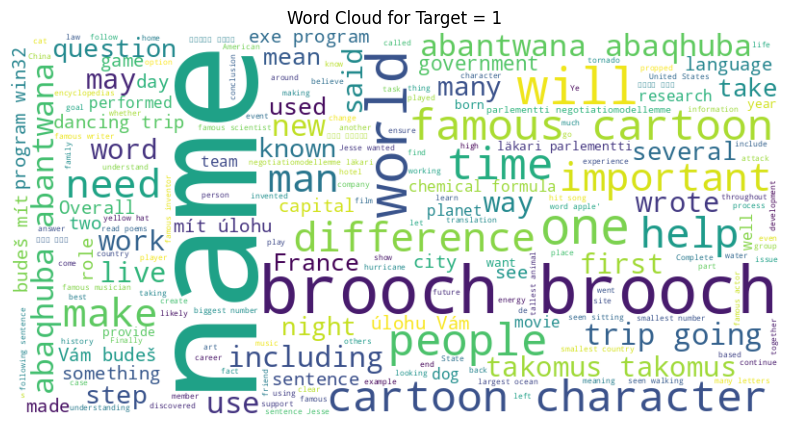

In [7]:
# EDA - Word Cloud for hallucinated & non-hallucinated responses
for label in [0, 1]:
    text = " ".join(df[df["Target"] == label]["Answer"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Target = {label}")
    plt.show()



Class Distribution:
 Target
0    15793
1      894
Name: count, dtype: int64


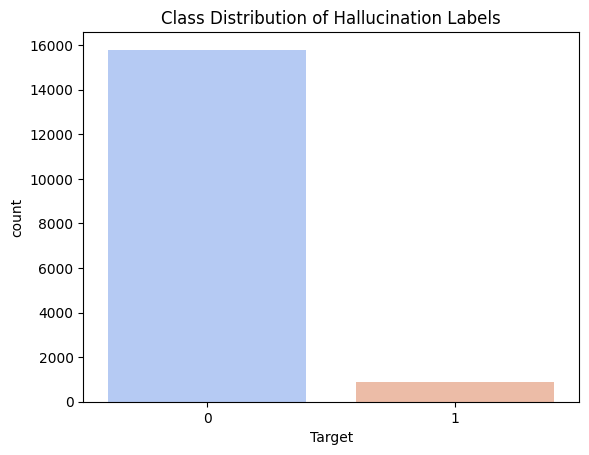

In [8]:
print("\nClass Distribution:\n", df["Target"].value_counts())
# Visualizing class distribution
sns.countplot(x=df["Target"], palette="coolwarm")
plt.title("Class Distribution of Hallucination Labels")
plt.show()

## Text Processing

In [9]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(lemmatized_tokens)

df["Processed_Text"] = df["Prompt"] + " " + df["Answer"]
df["Processed_Text"] = df["Processed_Text"].apply(preprocess_text)

## Feature extraction - TF-IDF 

In [10]:
# Feature Extraction (TF-IDF)
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df["Processed_Text"])
y = df["Target"]

SMOTE for Resampling

Class Distribution after Resampling:
Counter({0: 15793, 1: 15793})


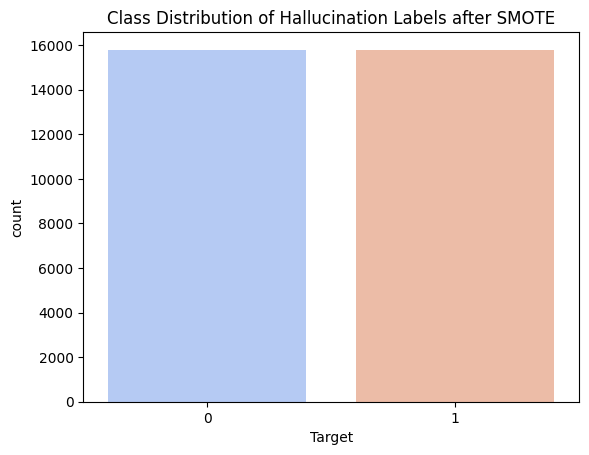

In [11]:
# Separate features (X) and target variable (y)
X = (df["Prompt"].astype(str) + " " + df["Answer"].astype(str)).tolist()
y = df["Target"]

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(vectorizer.fit_transform(X), y)


# Display the class distribution after resampling
print("Class Distribution after Resampling:")
print(Counter(y_resampled))

# Visualize the class distribution after resampling
sns.countplot(x=y_resampled, palette="coolwarm")
plt.title("Class Distribution of Hallucination Labels after SMOTE")
plt.show()

In [12]:
X_tfidf = X_resampled
y_tfidf = y_resampled

In [13]:
# Splitting Data
X_train, X_test, y_train, y_test_i = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)

## Feature Extraction - BERT embeddings

In [14]:
def get_bert_embeddings(text):
    tokens = bert_tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
def get_bert_embeddings(text):
    tokens = bert_tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.last_hidden_state[:, 0, :].cpu().numpy()  

In [17]:
# BERT Embeddings
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

y = df['Target']
df["BERT_Embeddings"] = df["Processed_Text"].apply(get_bert_embeddings)
X_bert = np.vstack(df["BERT_Embeddings"].values)
X_train_bert, X_test_bert, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### ADASYN for Resampling

In [18]:
from imblearn.over_sampling import ADASYN

# Apply ADASYN instead of RandomOverSampler
oversampler = ADASYN(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_bert, y)

In [19]:
X_bert = X_resampled
y_bert = y_resampled

In [21]:
import pickle

# Save embeddings & labels
with open("bert_embeddings.pkl", "wb") as f:
    pickle.dump((X_bert, y_bert), f)

with open("bert_embeddings.pkl", "rb") as f:
    X_bert, y_bert = pickle.load(f)


# Models

TFIDF LogisticRegression - Accuracy: 0.76, Precision: 0.80, Recall: 0.69, F1 Score: 0.74
Confusion Matrix:
 [[2693  521]
 [ 969 2135]]


<Figure size 1000x800 with 0 Axes>

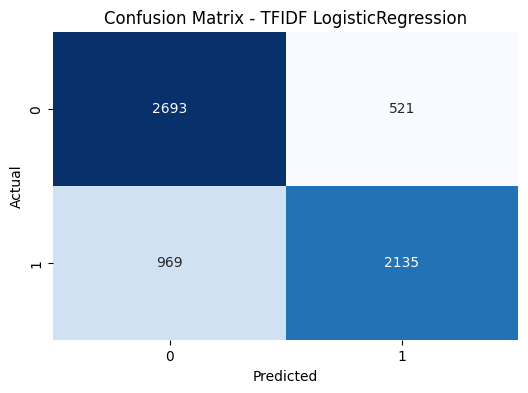

TFIDF RandomForest - Accuracy: 0.77, Precision: 0.85, Recall: 0.64, F1 Score: 0.73
Confusion Matrix:
 [[2873  341]
 [1109 1995]]


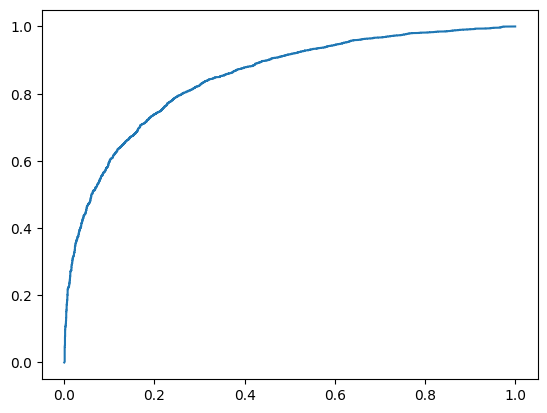

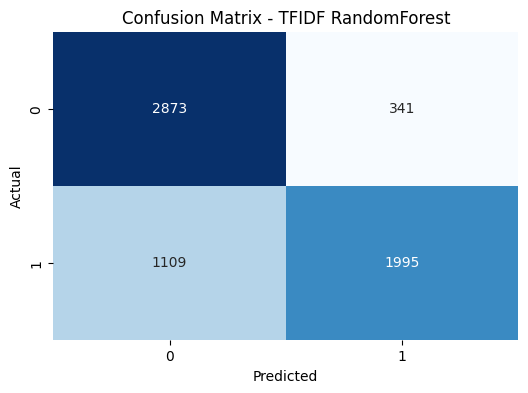

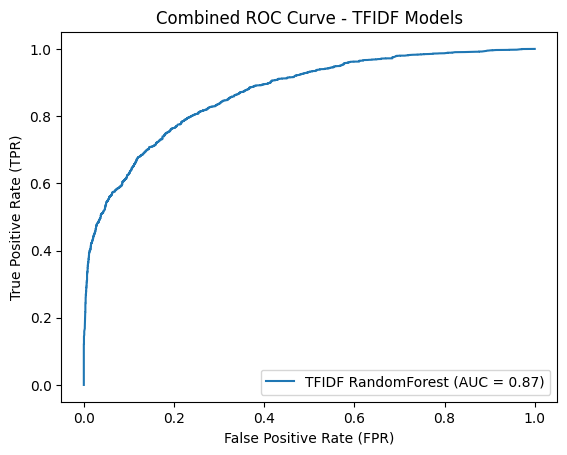

BERT LogisticRegression - Accuracy: 0.75, Precision: 0.73, Recall: 0.76, F1 Score: 0.75
Confusion Matrix:
 [[2336  878]
 [ 730 2374]]


<Figure size 1000x800 with 0 Axes>

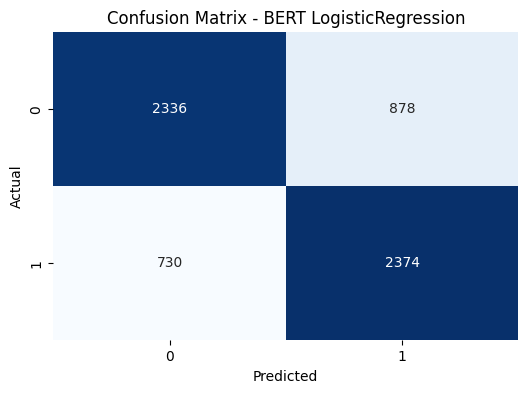

BERT RandomForest - Accuracy: 0.80, Precision: 0.80, Recall: 0.80, F1 Score: 0.80
Confusion Matrix:
 [[2576  638]
 [ 612 2492]]


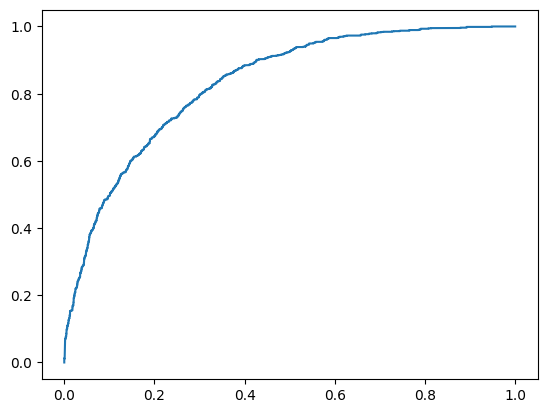

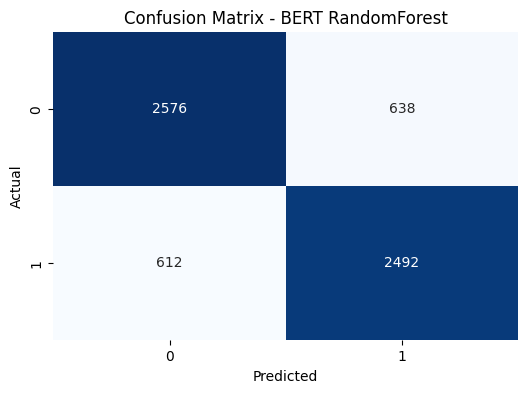

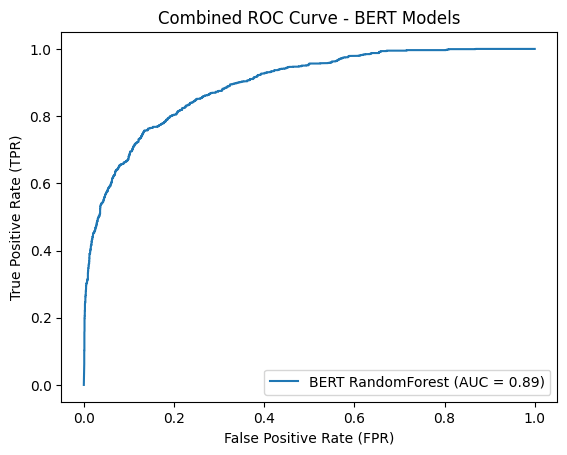

In [22]:
# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=50, penalty='l2', C=0.01, solver='liblinear'),
    'RandomForest': RandomForestClassifier(n_estimators=20, max_depth=5, max_features='sqrt')
}

# Function to evaluate models on test set
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    print(f"{name} - Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}")
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return fpr, tpr, roc_auc
X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(X_bert, y_bert, test_size=0.2, random_state=42)
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)

# Combined ROC curves for TFIDF models
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    fpr, tpr, roc_auc = evaluate_model(f'TFIDF {model_name}', model, X_tfidf_train, y_tfidf_train, X_tfidf_test, y_tfidf_test)
    plt.plot(fpr, tpr, label=f'TFIDF {model_name} (AUC = {roc_auc:.2f})')
plt.title("Combined ROC Curve - TFIDF Models")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.show()

# Combined ROC curves for BERT models
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    fpr, tpr, roc_auc = evaluate_model(f'BERT {model_name}', model, X_bert_train, y_bert_train, X_bert_test, y_bert_test)
    plt.plot(fpr, tpr, label=f'BERT {model_name} (AUC = {roc_auc:.2f})')
plt.title("Combined ROC Curve - BERT Models")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.show()

Accuracy: 0.9210
Precision: 0.9308
Recall: 0.9224
F1-Score: 0.9207


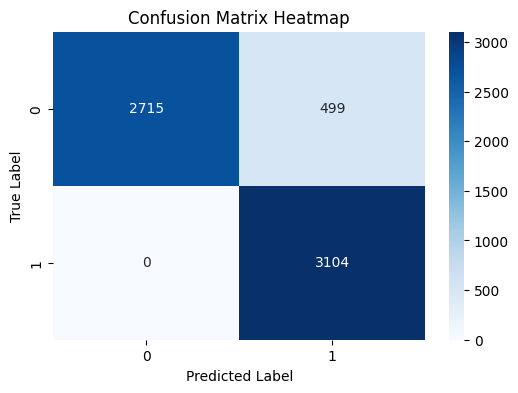

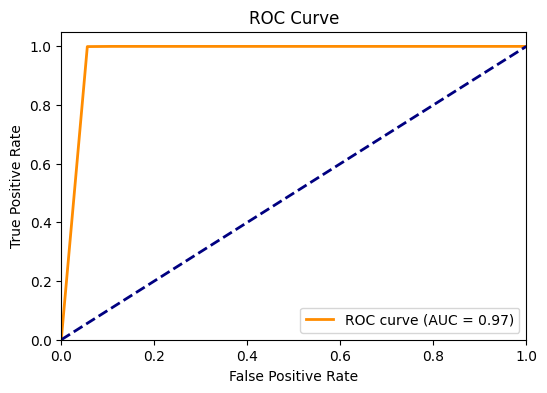

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_bert, y_bert, test_size=0.2, random_state=42)

# Initialize and train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predictions
y_pred = knn_model.predict(X_test)

# Calculate Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


# ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC curve (assuming binary classification)
y_test_binarized = label_binarize(y_test, classes=[0, 1])
y_pred_proba = knn_model.predict_proba(X_test)[:, 1]

# Calculate ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_binarized, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


# Dimentionality reduction

In [24]:
print(X_tfidf.shape)
print(X_bert.shape)

(31586, 77853)
(31586, 768)


Processing: TFIDF_SVD
	Model: LogisticRegression
	Model: RandomForest
	Model: KNN
Processing: TFIDF_SelectKBest


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:165: RuntimeWarning: divide by zero encountered in divide
  chisq /= f_exp


	Model: LogisticRegression
	Model: RandomForest
	Model: KNN
Processing: TFIDF_None
	Model: LogisticRegression
	Model: RandomForest
Processing: BERT_PCA
	Model: LogisticRegression
	Model: RandomForest
	Model: KNN
Processing: BERT_LDA
	Model: LogisticRegression
	Model: RandomForest
	Model: KNN
Processing: BERT_None
	Model: LogisticRegression
	Model: RandomForest
	Model: KNN


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


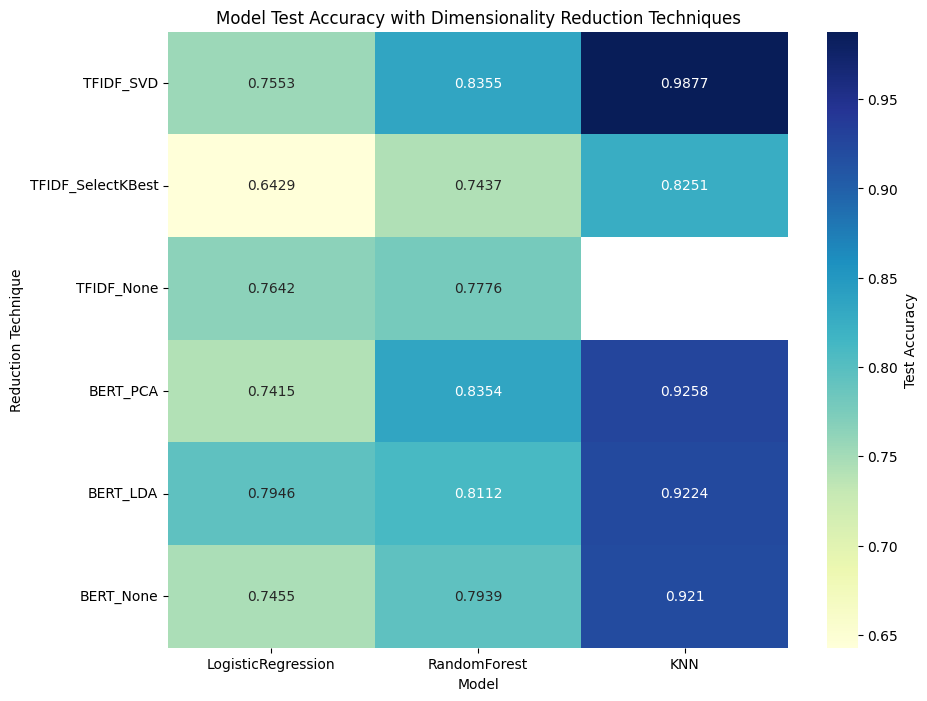

In [25]:
# Function for Dimensionality Reduction
def dimensionality_reduction(X_train, X_test, method, n_components):
    if method == 'PCA':
        reducer = PCA(n_components=n_components)
    elif method == 'LDA':
        reducer = LDA(n_components=1)
    elif method == 'TruncatedSVD':
        reducer = TruncatedSVD(n_components=n_components)
    elif method == 'SelectKBest':
        # Ensure n_components does not exceed number of features
        n_components = min(n_components, X_train.shape[1])
        reducer = SelectKBest(chi2, k=n_components)
    elif method == 'None':
        return X_train, X_test
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Fit on training data, transform both train and test
    if method in ['LDA', 'SelectKBest']:
        return reducer.fit_transform(X_train, y_train), reducer.transform(X_test)
    else:
        return reducer.fit_transform(X_train), reducer.transform(X_test)

# Models to Evaluate
models = {
    'LogisticRegression': LogisticRegression(max_iter=50, penalty='l2', C=0.01, solver='liblinear'),
    'RandomForest': RandomForestClassifier(n_estimators=20, max_depth=5, max_features='sqrt'),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Dimensionality Reduction Combinations
combinations = {
    'TFIDF_SVD': ('TruncatedSVD', X_tfidf, y_tfidf),
    'TFIDF_SelectKBest': ('SelectKBest', X_tfidf, y_tfidf),
    'TFIDF_None': ('None', X_tfidf, y_tfidf),
    'BERT_PCA': ('PCA', X_bert, y_bert),
    'BERT_LDA': ('LDA', X_bert, y_bert),
    'BERT_None': ('None', X_bert, y_bert)
}

results = {}

# Perform Dimensionality Reduction and Train Models
for combo_name, (method, X, y) in combinations.items():
    print(f"Processing: {combo_name}")
    
    try:
        # Split data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Reduce dimensions
        n_components = 500 if method not in ['SelectKBest', 'LDA'] else 50
        X_train_reduced, X_test_reduced = dimensionality_reduction(X_train, X_test, method, n_components=n_components)
        
        results[combo_name] = {}
        for model_name, model in models.items():
            # Skip KNN for TFIDF_None
            if combo_name == 'TFIDF_None' and model_name == 'KNN':
                results[combo_name][model_name] = float('nan')  # Represent skipped as NaN
                continue
            
            print(f"\tModel: {model_name}")
            model.fit(X_train_reduced, y_train)
            y_pred_test = model.predict(X_test_reduced)  # ✅ Predict on test set
            
            accuracy = accuracy_score(y_test, y_pred_test)  # ✅ Compute test accuracy
            results[combo_name][model_name] = round(accuracy, 4)
    
    except Exception as e:
        print(f"Error processing {combo_name} with {method}: {e}")
        results[combo_name] = {model_name: "Error" for model_name in models.keys()}

# Plot Heatmap of Test Accuracies
df_results = pd.DataFrame(results).T

# Create a mask for NaN values to show them as white in the heatmap
mask = df_results.isna()

plt.figure(figsize=(10, 8))
sns.heatmap(df_results, annot=True, cmap="YlGnBu", fmt=".4", mask=mask, cbar_kws={'label': 'Test Accuracy'})
plt.title("Model Test Accuracy with Dimensionality Reduction Techniques")
plt.xlabel("Model")
plt.ylabel("Reduction Technique")
plt.show()

# Hyperparameter Optimization

Processing Logistic+BERT+LDA


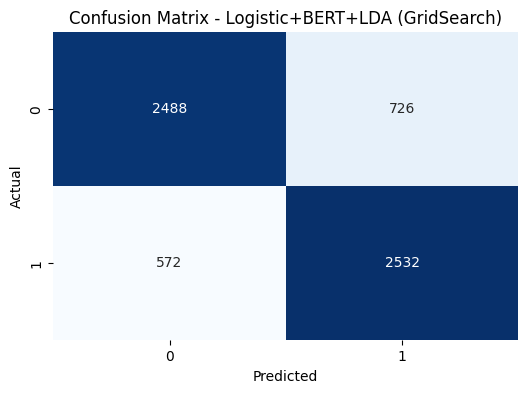

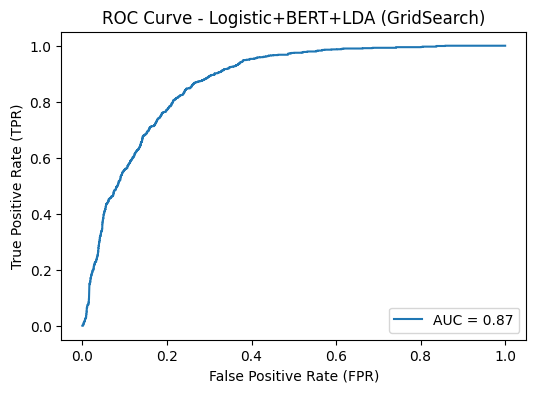

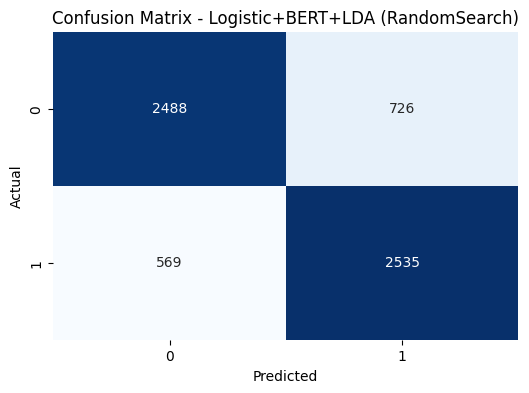

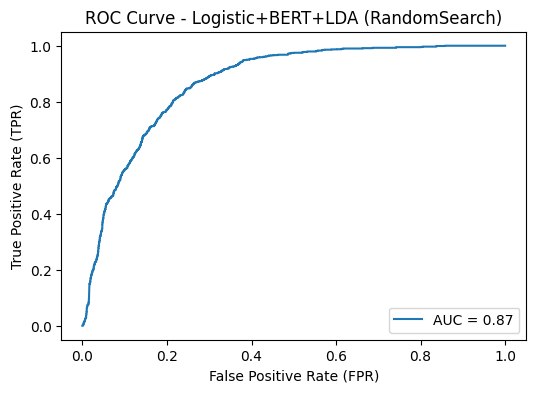

Processing RF+BERT+PCA


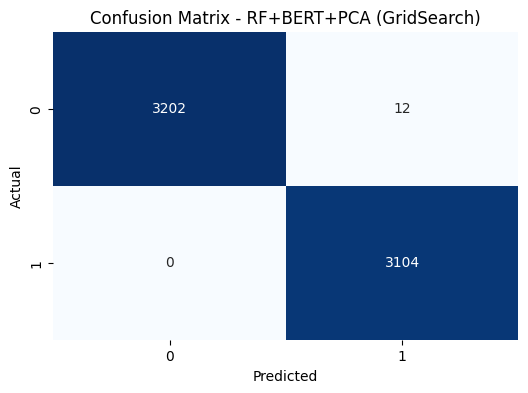

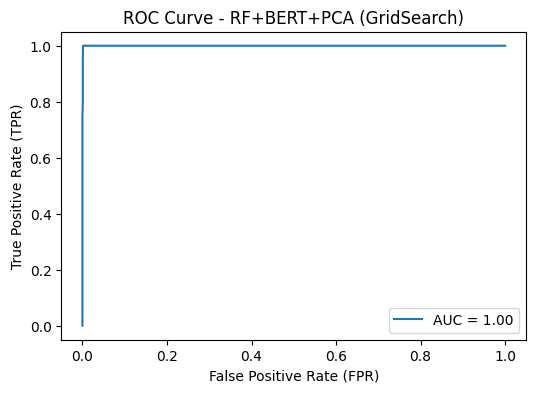

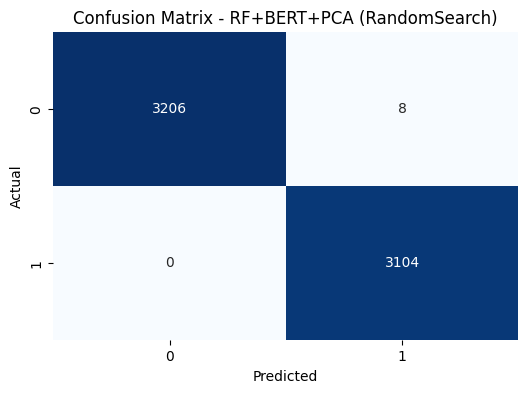

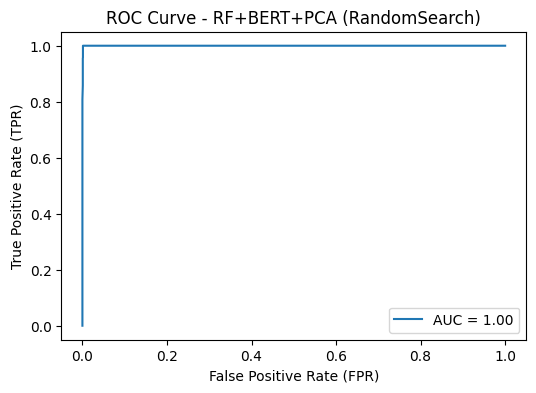

Processing KNN+TFIDF+SVD


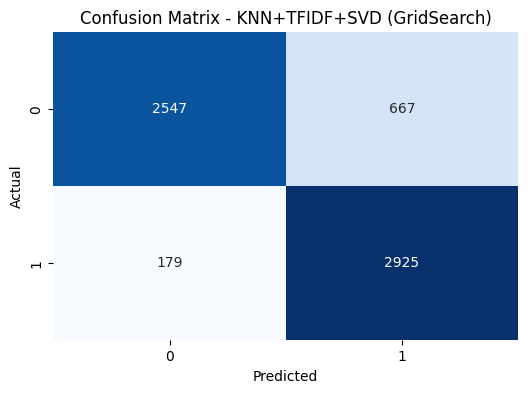

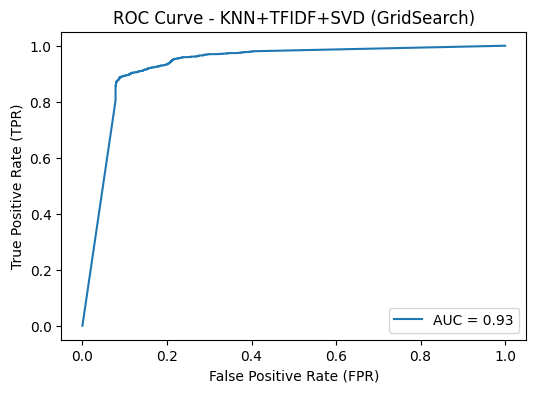

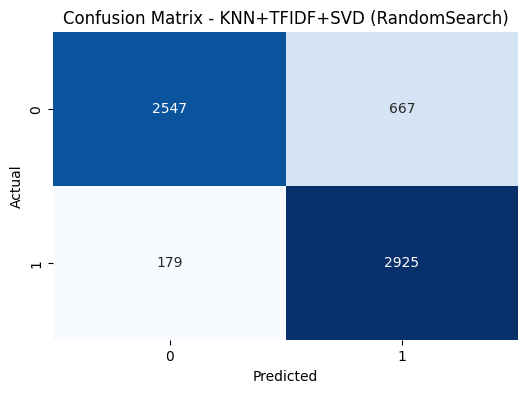

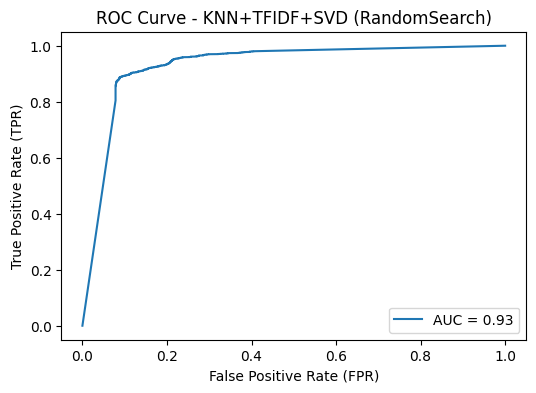

               Model   Search Type  \
0  Logistic+BERT+LDA    GridSearch   
1  Logistic+BERT+LDA  RandomSearch   
2        RF+BERT+PCA    GridSearch   
3        RF+BERT+PCA  RandomSearch   
4      KNN+TFIDF+SVD    GridSearch   
5      KNN+TFIDF+SVD  RandomSearch   

                                         Best Params  Train Accuracy  \
0                      {'C': 0.1, 'solver': 'lbfgs'}        0.810828   
1                  {'solver': 'liblinear', 'C': 0.1}        0.811145   
2              {'max_depth': 30, 'n_estimators': 20}        0.999802   
3              {'n_estimators': 40, 'max_depth': 30}        0.999802   
4  {'metric': 'manhattan', 'n_neighbors': 3, 'wei...        0.999842   
5  {'weights': 'distance', 'n_neighbors': 3, 'met...        0.999842   

   Test Accuracy  Precision    Recall  F1-Score  
0       0.794555   0.795118  0.794917  0.794545  
1       0.795030   0.795619  0.795401  0.795019  
2       0.998101   0.998074  0.998133  0.998100  
3       0.998734   0.998715 

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

# Define models and optimized parameters
models_params = {
    "Logistic+BERT+LDA": (
        LogisticRegression(max_iter=50, penalty='l2'), 
        {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear']}, 
        LDA(n_components=1)
    ),
    "RF+BERT+PCA": (
        RandomForestClassifier(), 
        {'n_estimators': [20, 30, 40], 'max_depth': [5, 10, 20, 30]}, 
        PCA(n_components=10)
    ),
    "KNN+TFIDF+SVD": (
        KNeighborsClassifier(), 
        {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}, 
        TruncatedSVD(n_components=10)
    )
}

# Prepare results dataframe
results = []

for model_name, (model, param_grid, reducer) in models_params.items():
    print(f"Processing {model_name}")
    
    # Select appropriate dataset and split into train/test
    if "TFIDF" in model_name:
        X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_bert, y_bert, test_size=0.2, random_state=42)

    # Dimensionality reduction
    if isinstance(reducer, LDA):
        X_train_reduced = reducer.fit_transform(X_train, y_train)
        X_test_reduced = reducer.transform(X_test)
    else:
        X_train_reduced = reducer.fit_transform(X_train)
        X_test_reduced = reducer.transform(X_test)

    # Grid Search and Random Search
    for search_name, search in zip(
        ["GridSearch", "RandomSearch"], 
        [GridSearchCV(model, param_grid, cv=5, scoring='accuracy'), 
         RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_iter=10, random_state=42)]
    ):
        search.fit(X_train_reduced, y_train)
        best_model = search.best_estimator_

        # Train accuracy
        y_pred_train = best_model.predict(X_train_reduced)
        # Test accuracy and evaluation
        y_pred_test = best_model.predict(X_test_reduced)
        y_prob = best_model.predict_proba(X_test_reduced)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_test_reduced)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_test)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix - {model_name} ({search_name})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.title(f"ROC Curve - {model_name} ({search_name})")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.legend(loc="lower right")
        plt.show()

        # Store results with optimized hyperparameters
        results.append({
            "Model": model_name,
            "Search Type": search_name,
            "Best Params": search.best_params_,  # Include optimized hyperparameters
            "Train Accuracy": accuracy_score(y_train, y_pred_train),
            "Test Accuracy": accuracy_score(y_test, y_pred_test),
            "Precision": precision_score(y_test, y_pred_test, average='macro'),
            "Recall": recall_score(y_test, y_pred_test, average='macro'),
            "F1-Score": f1_score(y_test, y_pred_test, average='macro')
        })

# Convert results to DataFrame and print
results_df = pd.DataFrame(results)
print(results_df)


In [27]:
pd.set_option('display.max_colwidth', None)
print(results_df[['Model', 'Best Params']])


               Model  \
0  Logistic+BERT+LDA   
1  Logistic+BERT+LDA   
2        RF+BERT+PCA   
3        RF+BERT+PCA   
4      KNN+TFIDF+SVD   
5      KNN+TFIDF+SVD   

                                                        Best Params  
0                                     {'C': 0.1, 'solver': 'lbfgs'}  
1                                 {'solver': 'liblinear', 'C': 0.1}  
2                             {'max_depth': 30, 'n_estimators': 20}  
3                             {'n_estimators': 40, 'max_depth': 30}  
4  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}  
5  {'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan'}  


# Cross Validation

Processing Logistic+BERT+LDA


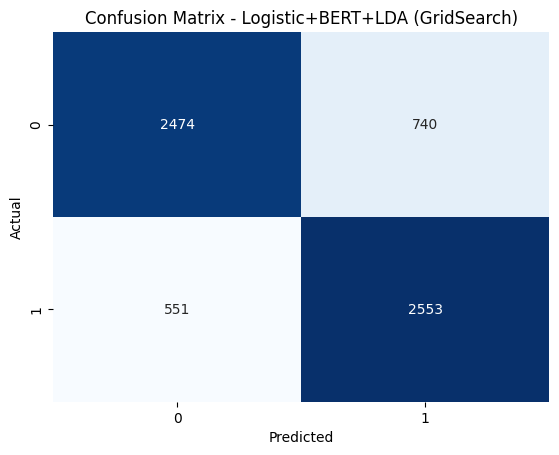

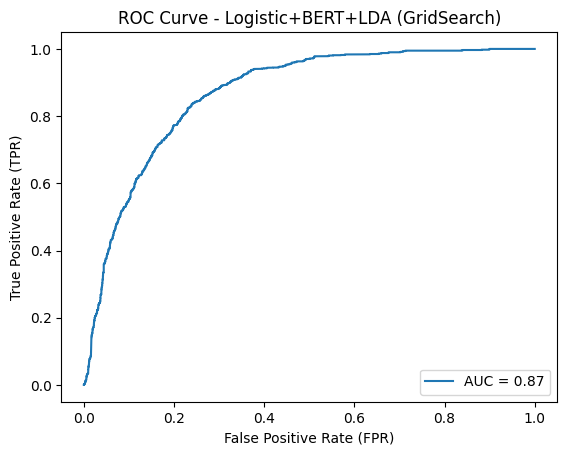

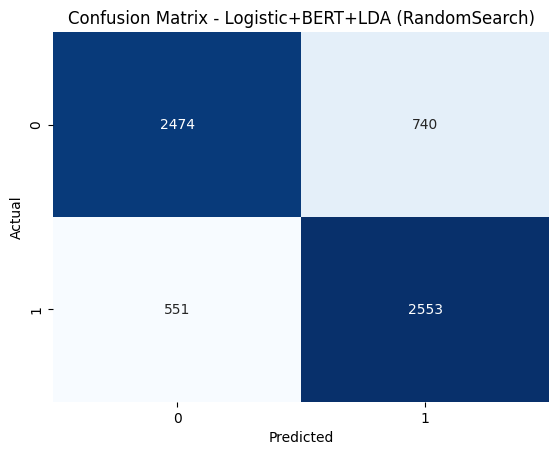

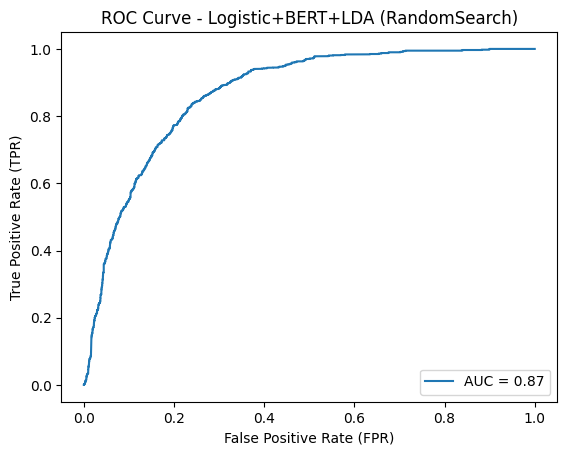

Processing RF+BERT+PCA


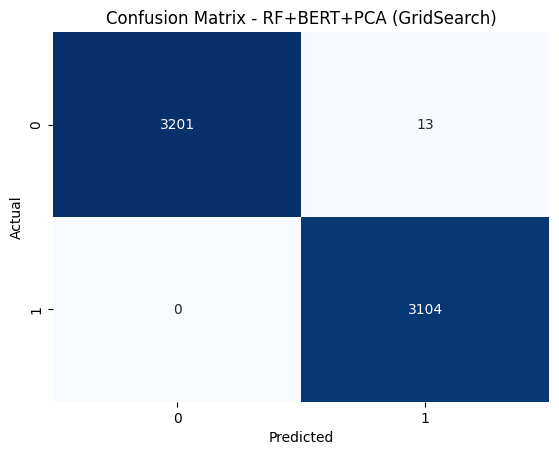

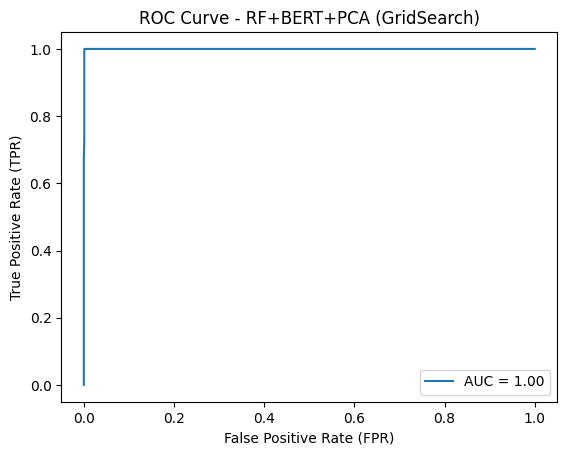

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

# Define models and optimized parameters
models_params = {
    "Logistic+BERT+LDA": (
        LogisticRegression(max_iter=50, penalty='l2'), 
        {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear']}, 
        LDA(n_components=1)
    ),
    "RF+BERT+PCA": (
        RandomForestClassifier(), 
        {'n_estimators': [20, 30, 40], 'max_depth': [5, 10, 20, 30]}, 
        PCA(n_components=10)
    ),
    "KNN+TFIDF+SVD": (
        KNeighborsClassifier(), 
        {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}, 
        TruncatedSVD(n_components=10)
    )
}

# Prepare results dataframe
results = []

for model_name, (model, param_grid, reducer) in models_params.items():
    print(f"Processing {model_name}")
    # Select appropriate dataset and split into train/val/test
    if "TFIDF" in model_name:
        X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_bert, y_bert, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # Dimensionality reduction
    if isinstance(reducer, LDA):
        X_train_reduced = reducer.fit_transform(X_train, y_train)
        X_val_reduced = reducer.transform(X_val)
        X_test_reduced = reducer.transform(X_test)
    else:
        X_train_reduced = reducer.fit_transform(X_train)
        X_val_reduced = reducer.transform(X_val)
        X_test_reduced = reducer.transform(X_test)

    # Grid Search and Random Search
    for search_name, search in zip([
        "GridSearch", "RandomSearch"], [
        GridSearchCV(model, param_grid, cv=5, scoring='accuracy'), 
        RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_iter=10, random_state=42)
    ]):
        search.fit(X_train_reduced, y_train)
        best_model = search.best_estimator_

        # Cross-Validation
        cv_scores = cross_val_score(best_model, X_val_reduced, y_val, cv=5, scoring='accuracy')

        # Test accuracy and evaluation
        y_pred_test = best_model.predict(X_test_reduced)
        y_prob = best_model.predict_proba(X_test_reduced)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_test_reduced)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_test)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix - {model_name} ({search_name})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.title(f"ROC Curve - {model_name} ({search_name})")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.legend(loc="lower right")
        plt.show()

        # Store results
        results.append({
            "Model": model_name,
            "Search Type": search_name,
            "Best Params": search.best_params_,
            "Cross-Val Accuracy": np.mean(cv_scores),
            "Test Accuracy": accuracy_score(y_test, y_pred_test),
            "Precision": precision_score(y_test, y_pred_test, average='macro'),
            "Recall": recall_score(y_test, y_pred_test, average='macro'),
            "F1-Score": f1_score(y_test, y_pred_test, average='macro')
        })

# Convert results to DataFrame and print
results_df = pd.DataFrame(results)
print(results_df)


# Ensemble Models

Processing: TFIDF_SVD
	Model: AdaBoost
0.8850324521133449 0.8760683760683761
	Model: XGBoost
0.9995250910242204 0.9808483697372586
	Model: GradientBoost
0.9085008706664556 0.8847736625514403
Processing: TFIDF_SelectKBest


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:165: RuntimeWarning: divide by zero encountered in divide
  chisq /= f_exp


	Model: AdaBoost
0.7762387209118252 0.7896486229819563
	Model: XGBoost
0.8621972455279405 0.8452041785375118
	Model: GradientBoost
0.8000633211967706 0.8018360240582463
Processing: TFIDF_None
	Model: AdaBoost
0.8818268165268324 0.8748021525799303
	Model: XGBoost
0.9886813360772518 0.9711934156378601
	Model: GradientBoost
0.8968656007598543 0.8922127255460589
Processing: BERT_PCA
	Model: AdaBoost
0.8438212585510261 0.83984
	Model: XGBoost
0.9998399807976958 0.99344
	Model: GradientBoost
0.9018282193863264 0.88848
Processing: BERT_LDA
	Model: AdaBoost
0.8306596791614994 0.81888
	Model: XGBoost
0.8313797655718687 0.81984
	Model: GradientBoost
0.8311797415689883 0.81952
Processing: BERT_None
	Model: AdaBoost
0.7781333760051207 0.76192
	Model: XGBoost
0.9998399807976958 0.98256
	Model: GradientBoost
0.8353802456294755 0.81696


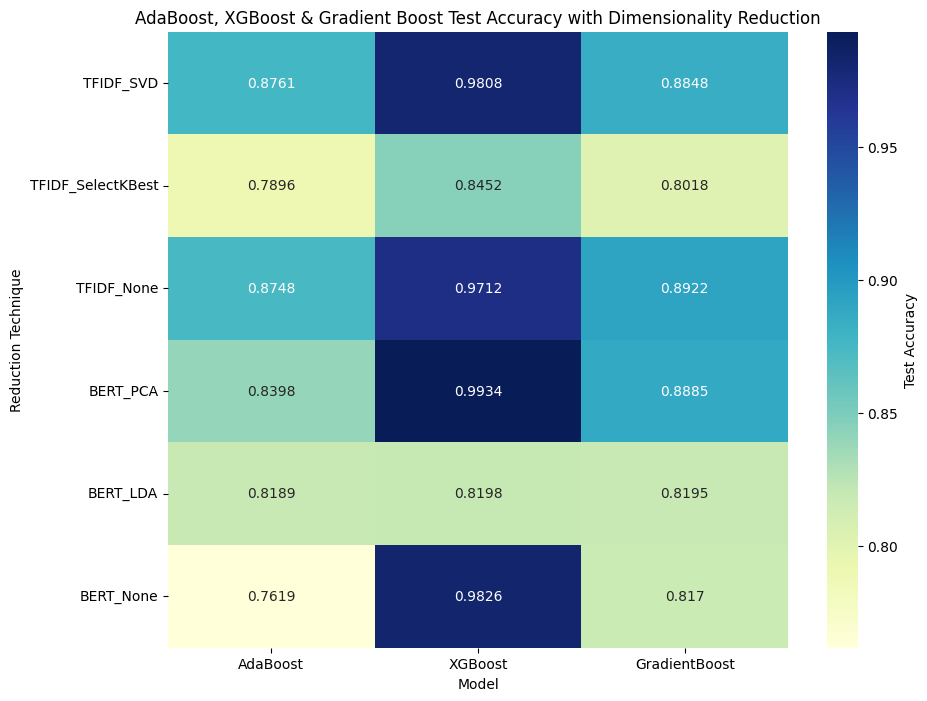

In [20]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function for Dimensionality Reduction
def dimensionality_reduction(X_train, X_test, method, n_components):
    if method == 'PCA':
        reducer = PCA(n_components=n_components)
    elif method == 'LDA':
        reducer = LDA(n_components=1)
    elif method == 'TruncatedSVD':
        reducer = TruncatedSVD(n_components=n_components)
    elif method == 'SelectKBest':
        n_components = min(n_components, X_train.shape[1])
        reducer = SelectKBest(chi2, k=n_components)
    elif method == 'None':
        return X_train, X_test
    else:
        raise ValueError(f"Unknown method: {method}")
    
    if method in ['LDA', 'SelectKBest']:
        return reducer.fit_transform(X_train, y_train), reducer.transform(X_test)
    else:
        return reducer.fit_transform(X_train), reducer.transform(X_test)

# Models to Evaluate (Now includes AdaBoost, XGBoost, Gradient Boosting)
models = {
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),
    'GradientBoost': GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42)
}

# Dimensionality Reduction Combinations
combinations = {
    'TFIDF_SVD': ('TruncatedSVD', X_tfidf, y_tfidf),
    'TFIDF_SelectKBest': ('SelectKBest', X_tfidf, y_tfidf),
    'TFIDF_None': ('None', X_tfidf, y_tfidf),
    'BERT_PCA': ('PCA', X_bert, y_bert),
    'BERT_LDA': ('LDA', X_bert, y_bert),
    'BERT_None': ('None', X_bert, y_bert)
}

results = {}

# Perform Dimensionality Reduction and Train Models
for combo_name, (method, X, y) in combinations.items():
    print(f"Processing: {combo_name}")
    
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        n_components = 500 if method not in ['SelectKBest', 'LDA'] else 50
        X_train_reduced, X_test_reduced = dimensionality_reduction(X_train, X_test, method, n_components=n_components)
        
        results[combo_name] = {}
        for model_name, model in models.items():
            print(f"\tModel: {model_name}")
            model.fit(X_train_reduced, y_train)
            y_pred = model.predict(X_train_reduced)
            accuracy1 = accuracy_score(y_train, y_pred)
            y_pred_test = model.predict(X_test_reduced)
            accuracy = accuracy_score(y_test, y_pred_test)
            print(accuracy1,accuracy)
            results[combo_name][model_name] = round(accuracy, 4)
    
    except Exception as e:
        print(f"Error processing {combo_name} with {method}: {e}")
        results[combo_name] = {model_name: "Error" for model_name in models.keys()}

# Plot Heatmap of Test Accuracies
df_results = pd.DataFrame(results).T
mask = df_results.isna()

plt.figure(figsize=(10, 8))
sns.heatmap(df_results, annot=True, cmap="YlGnBu", fmt=".4", mask=mask, cbar_kws={'label': 'Test Accuracy'})
plt.title("AdaBoost, XGBoost & Gradient Boost Test Accuracy with Dimensionality Reduction")
plt.xlabel("Model")
plt.ylabel("Reduction Technique")
plt.show()

Processing AdaBoost+TFIDF+SVD


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py", line 124, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/skle

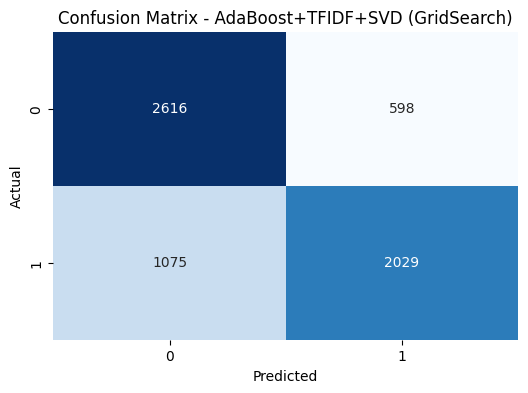

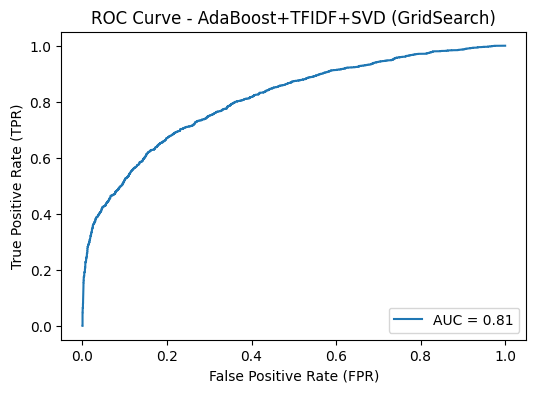

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py", line 124, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/skle

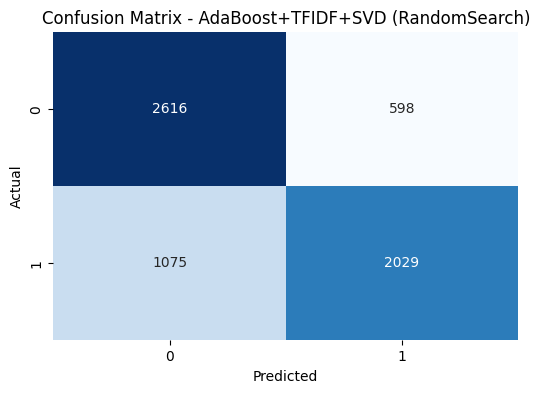

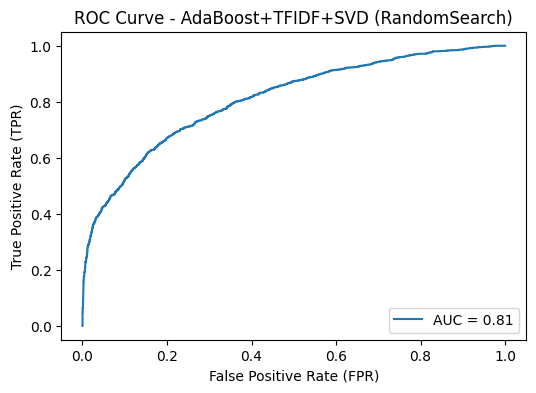

Processing XGBoost+BERT+PCA


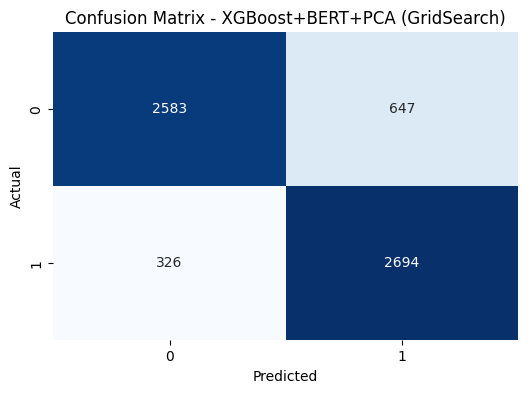

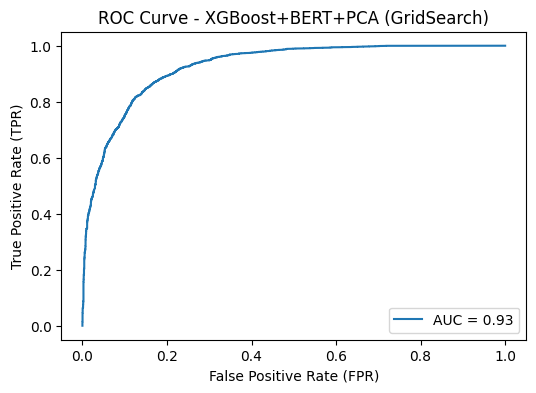

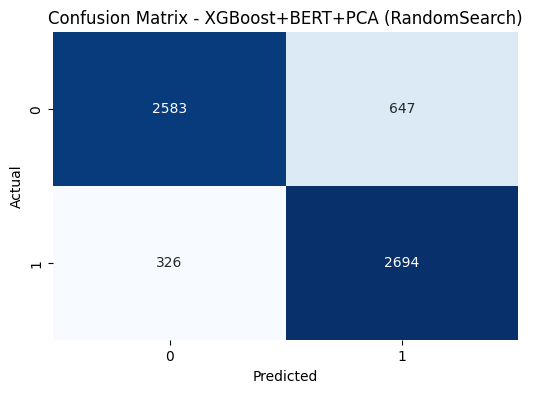

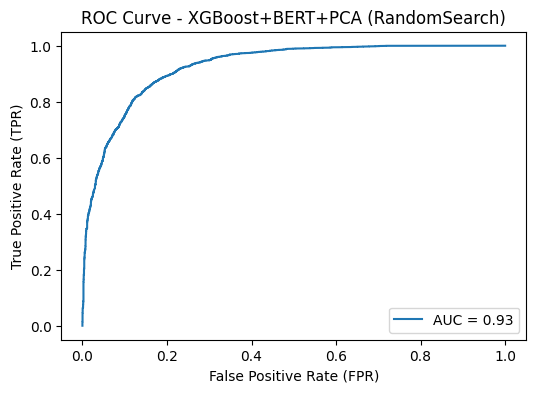

                Model   Search Type  \
0  AdaBoost+TFIDF+SVD    GridSearch   
1  AdaBoost+TFIDF+SVD  RandomSearch   
2    XGBoost+BERT+PCA    GridSearch   
3    XGBoost+BERT+PCA  RandomSearch   

                                         Best Params  Train Accuracy  \
0          {'learning_rate': 1, 'n_estimators': 150}        0.746636   
1          {'n_estimators': 150, 'learning_rate': 1}        0.746636   
2  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...        0.899948   
3  {'n_estimators': 100, 'max_depth': 7, 'learnin...        0.899948   

   Test Accuracy  Precision    Recall  F1-Score  
0       0.735201   0.740557  0.733806  0.732895  
1       0.735201   0.740557  0.733806  0.732895  
2       0.844320   0.847140  0.845872  0.844271  
3       0.844320   0.847140  0.845872  0.844271  


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Define updated models and parameters
models_params = {
    "AdaBoost+TFIDF+SVD": (
        AdaBoostClassifier(random_state=42), 
        {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 1, None]}, 
        TruncatedSVD(n_components=10)
    ),
    "XGBoost+BERT+PCA": (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0), 
        {'n_estimators': [50, 100], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]}, 
        PCA(n_components=10)
    )
}

# Prepare results list
results = []

# Loop through model combinations
for model_name, (model, param_grid, reducer) in models_params.items():
    print(f"Processing {model_name}")
    
    # Dataset selection
    if "TFIDF" in model_name:
        X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_bert, y_bert, test_size=0.2, random_state=42)

    # Dimensionality reduction
    if isinstance(reducer, LDA):
        X_train_reduced = reducer.fit_transform(X_train, y_train)
        X_test_reduced = reducer.transform(X_test)
    else:
        X_train_reduced = reducer.fit_transform(X_train)
        X_test_reduced = reducer.transform(X_test)

    # Perform Grid Search and Random Search
    for search_name, search in zip(
        ["GridSearch", "RandomSearch"], 
        [GridSearchCV(model, param_grid, cv=5, scoring='accuracy'), 
         RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_iter=10, random_state=42)]
    ):
        search.fit(X_train_reduced, y_train)
        best_model = search.best_estimator_

        # Predictions and metrics
        y_pred_train = best_model.predict(X_train_reduced)
        y_pred_test = best_model.predict(X_test_reduced)

        try:
            y_prob = best_model.predict_proba(X_test_reduced)[:, 1]
        except:
            y_prob = best_model.decision_function(X_test_reduced)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred_test)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix - {model_name} ({search_name})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.title(f"ROC Curve - {model_name} ({search_name})")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.legend(loc="lower right")
        plt.show()

        # Store metrics
        results.append({
            "Model": model_name,
            "Search Type": search_name,
            "Best Params": search.best_params_,
            "Train Accuracy": accuracy_score(y_train, y_pred_train),
            "Test Accuracy": accuracy_score(y_test, y_pred_test),
            "Precision": precision_score(y_test, y_pred_test, average='macro'),
            "Recall": recall_score(y_test, y_pred_test, average='macro'),
            "F1-Score": f1_score(y_test, y_pred_test, average='macro')
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)


# Contest Submmissions

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    stop_words = set(["a", "an", "the", "and", "or", "but"])  # Basic stop words (customize as needed)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# BERT Embeddings
def get_bert_embeddings(text):
    tokens = bert_tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.last_hidden_state[:, 0, :].cpu().numpy()

# Load test data
test_df = pd.read_csv("/kaggle/input/ml-olympiad-detect-hallucinations-in-llms/test.csv")
test_df["Prompt"] = test_df["Prompt"].fillna("")
test_df["Answer"] = test_df["Answer"].fillna("")
test_df["Processed_Text"] = (test_df["Prompt"] + " " + test_df["Answer"]).apply(preprocess_text)
X_test_bert = np.vstack(test_df["Processed_Text"].apply(get_bert_embeddings))

# PCA Transformation
pca = PCA(n_components=10, random_state=42)
X_train_pca = pca.fit_transform(X_bert)
X_test_pca = pca.transform(X_test_bert)

# Train Random Forest model with specified parameters
rf_model = RandomForestClassifier(n_estimators=40, max_depth=30, random_state=42)
rf_model.fit(X_train_pca, y_bert)

# Predictions on test data
y_pred = rf_model.predict(X_test_pca)

# Save to submission.csv
submission = pd.DataFrame({"Id": test_df["Id"], "Target": y_pred})
submission.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv")

In [ ]:
test_df.columns

In [ ]:
# Fit the vectorizer on the training data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(df["Processed_Text"])

# Transform the test data using the fitted vectorizer
X_test_tfidf = vectorizer.transform(test_df["Processed_Text"])

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

# Text Preprocessing
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    stop_words = set(["a", "an", "the", "and", "or", "but"])
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# BERT Embeddings
def get_bert_embeddings(text):
    tokens = bert_tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.last_hidden_state[:, 0, :].cpu().numpy()

# Models and best params
models_params = {
    "Logistic+BERT+LDA": (LogisticRegression(C=0.1, solver='lbfgs'), LDA(n_components=1)),
    "RF+BERT+PCA": (RandomForestClassifier(n_estimators=40, max_depth=30), PCA(n_components=10)),
    "Gradient+BERT+PCA": (GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=100), PCA(n_components=10)),
    "KNN+TFIDF+SVD": (KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='distance'), TruncatedSVD(n_components=10))
}

# Load test data
test_df = pd.read_csv("/kaggle/input/ml-olympiad-detect-hallucinations-in-llms/test.csv")
test_df["Prompt"] = test_df["Prompt"].fillna("")
test_df["Answer"] = test_df["Answer"].fillna("")
test_df["Processed_Text"] = (test_df["Prompt"] + " " + test_df["Answer"]).apply(preprocess_text)
X_test_bert = np.vstack(test_df["Processed_Text"].apply(get_bert_embeddings))

# Predictions
def predict_and_save(model, reducer, model_name):
    if isinstance(reducer, LDA):
        X_train_reduced = reducer.fit_transform(X_bert, y_bert)
        X_test_reduced = reducer.transform(X_test_bert)
    else:
        X_train_reduced = reducer.fit_transform(X_bert)
        X_test_reduced = reducer.transform(X_test_bert)
    model.fit(X_train_reduced, y_bert)
    y_pred = model.predict(X_test_reduced)
    submission = pd.DataFrame({"Id": test_df["Id"], "Target": y_pred})
    submission.to_csv(f"submission_{model_name}.csv", index=False)
    print(f"Submission for {model_name} saved.")

# Run predictions for all models
for model_name, (model, reducer) in models_params.items():
    predict_and_save(model, reducer, model_name)


In [ ]:
# Fit the vectorizer on the training data
vectorizer = TfidfVectorizer()
X_train_bert = vectorizer.fit_transform(df["Processed_Text"])

# Transform the test data using the fitted vectorizer
X_test_bert = vectorizer.transform(test_df["Processed_Text"])

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

# Text Preprocessing
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    stop_words = set(["a", "an", "the", "and", "or", "but"])
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# BERT Embeddings
def get_tfidf_embeddings(text):
    tokens = bert_tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.last_hidden_state[:, 0, :].cpu().numpy()

# Models and best params
models_params = {
    "Logistic+TFIDF+SelectKBest": (LogisticRegression(C=0.1, solver='lbfgs'), SelectKBest(k=1)),
    "RF+TFIDF+SVD": (RandomForestClassifier(n_estimators=40, max_depth=30), TruncatedSVD(n_components=10)),
    "Gradient+TFIDF+SVD": (GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=100), TruncatedSVD(n_components=10)),
    "KNN+BERT+PCA": (KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='distance'), PCA(n_components=10))
}

# Load test data
test_df = pd.read_csv("/kaggle/input/ml-olympiad-detect-hallucinations-in-llms/test.csv")
test_df["Prompt"] = test_df["Prompt"].fillna("")
test_df["Answer"] = test_df["Answer"].fillna("")
test_df["Processed_Text"] = (test_df["Prompt"] + " " + test_df["Answer"]).apply(preprocess_text)
X_test_tfidf = np.vstack(test_df["Processed_Text"].apply(get_tfidf_embeddings))

# Predictions
def predict_and_save(model, reducer, model_name):
    if isinstance(reducer, SelectKBest):
        X_train_reduced = reducer.fit_transform(X_tfidf.toarray(), y_tfidf)
        X_test_reduced = reducer.transform(X_test_tfidf.toarray())
    else:
        X_train_reduced = reducer.fit_transform(X_tfidf)
        X_test_reduced = reducer.transform(X_test_tfidf)
    model.fit(X_train_reduced, y_tfidf)
    y_pred = model.predict(X_test_reduced)
    submission = pd.DataFrame({"Id": test_df["Id"], "Target": y_pred})
    submission.to_csv(f"submission_{model_name}.csv", index=False)
    print(f"Submission for {model_name} saved.")

# Run predictions for all models
for model_name, (model, reducer) in models_params.items():
    predict_and_save(model, reducer, model_name)


# Saving the model

In [ ]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Assuming X_bert and y_bert are your training features and labels
# Replace with your actual data
# Example:
# X_bert = np.array([...])
# y_bert = np.array([...])

# Model and Reducer (using the best parameters from your code)
model = LogisticRegression(C=0.1, solver='lbfgs')
reducer = LDA(n_components=1)

# Fit the model
X_train_reduced = reducer.fit_transform(X_bert, y_bert)
model.fit(X_train_reduced, y_bert)

# Save the model and reducer
joblib.dump(model, 'logistic_model.pkl')
joblib.dump(reducer, 'lda_reducer.pkl')
